In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
import nltk
from wordcloud import WordCloud
from collections import Counter
import re

In [2]:
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("NLTK data download skipped - may already exist")

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("Set2")

print("="*60)
print("DAY 2: COMPREHENSIVE EDA & ADVANCED ANALYSIS")
print("Member: ITBIN-2211-0184 - EDA & Documentation")
print("Time: 9:00 AM - 6:00 PM")
print("="*60)

DAY 2: COMPREHENSIVE EDA & ADVANCED ANALYSIS
Member: ITBIN-2211-0184 - EDA & Documentation
Time: 9:00 AM - 6:00 PM


In [3]:
try:
    df = pd.read_csv('../data/processed/test_processed.csv')
    print(f"Loaded processed dataset: {df.shape}")
except:
    print("Processed data not found. Loading from raw data...")
    # Load raw data if processed doesn't exist
    columns = ['label', 'statement', 'subject', 'speaker', 'speaker_job','state_info', 'party_affiliation', 'barely_true_counts','false_counts', 'half_true_counts', 'mostly_true_counts','pants_fire_counts', 'context']
    
    train_df = pd.read_csv('../data/processed/train.tsv', sep='\t', names=columns, header=None)
    test_df = pd.read_csv('../data/processed/test_processed.csv', sep='\t', names=columns, header=None)
    valid_df = pd.read_csv('../data/processed/valid.tsv', sep='\t', names=columns, header=None)
    
    train_df['split'] = 'train'
    test_df['split'] = 'test'
    valid_df['split'] = 'valid'
    
    df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
    
    # Recalculate features
    df['text_length'] = df['statement'].astype(str).str.len()
    df['word_count'] = df['statement'].astype(str).str.split().str.len()
    
    credibility_cols = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                       'mostly_true_counts', 'pants_fire_counts']
    for col in credibility_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    df['total_statements'] = df[credibility_cols].sum(axis=1)
    df['credibility_score'] = (df['mostly_true_counts'] + df['half_true_counts'] * 0.5) / (df['total_statements'] + 1)


Loaded processed dataset: (1267, 14)


In [4]:
def advanced_text_analysis(df):
    """Perform advanced text analysis with linguistic features"""
    print("\n" + "="*50)
    print("ADVANCED TEXT ANALYSIS")
    print("="*50)
    
    # Import additional text analysis tools
    try:
        from textstat import flesch_reading_ease, flesch_kincaid_grade
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        
        # Initialize sentiment analyzer
        sia = SentimentIntensityAnalyzer()
        
        # Calculate linguistic features
        print("Calculating linguistic features...")
        
        # Readability scores
        df['flesch_ease'] = df['statement'].astype(str).apply(
            lambda x: flesch_reading_ease(x) if len(x) > 10 else 0
        )
        df['flesch_grade'] = df['statement'].astype(str).apply(
            lambda x: flesch_kincaid_grade(x) if len(x) > 10 else 0
        )
        
        # Sentiment analysis
        sentiment_scores = df['statement'].astype(str).apply(
            lambda x: sia.polarity_scores(x)
        )
        df['sentiment_positive'] = sentiment_scores.apply(lambda x: x['pos'])
        df['sentiment_negative'] = sentiment_scores.apply(lambda x: x['neg'])
        df['sentiment_neutral'] = sentiment_scores.apply(lambda x: x['neu'])
        df['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])
        
        print("Linguistic features calculated!")
        
    except ImportError:
        print("Some text analysis libraries not available. Installing...")
        import subprocess
        subprocess.run(['pip', 'install', 'textstat', 'vaderSentiment'], 
                      capture_output=True, text=True)
        print("Libraries installed. Please restart notebook.")
        
        # Fallback simpler analysis
        df['flesch_ease'] = 50  # Default moderate readability
        df['sentiment_compound'] = 0  # Neutral sentiment
    
    # Additional text features
    df['avg_word_length'] = df['statement'].astype(str).apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )
    df['exclamation_count'] = df['statement'].astype(str).str.count('!')
    df['question_count'] = df['statement'].astype(str).str.count(r'\?')
    df['caps_ratio'] = df['statement'].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    
    # Text complexity
    df['unique_word_ratio'] = df.apply(
        lambda row: len(set(str(row['statement']).lower().split())) / row['word_count'] 
        if row['word_count'] > 0 else 0, axis=1
    )
    
    return df

In [5]:
def create_linguistic_visualizations(df):
    """Create comprehensive linguistic analysis visualizations"""
    print("\nCreating linguistic visualizations...")
    
    # Create subplot figure
    fig, axes = plt.subplots(3, 4, figsize=(20, 18))
    fig.suptitle('Advanced Linguistic Analysis', fontsize=16, fontweight='bold')
    
    # 1. Readability by Label
    if 'flesch_ease' in df.columns:
        sns.boxplot(data=df, x='label', y='flesch_ease', ax=axes[0,0])
        axes[0,0].set_title('Readability Score by Label')
        axes[0,0].set_xlabel('Truth Label')
        axes[0,0].set_ylabel('Flesch Reading Ease')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Sentiment by Label
    if 'sentiment_compound' in df.columns:
        sns.boxplot(data=df, x='label', y='sentiment_compound', ax=axes[0,1])
        axes[0,1].set_title('Sentiment by Label')
        axes[0,1].set_xlabel('Truth Label')
        axes[0,1].set_ylabel('Compound Sentiment Score')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Average Word Length
    if 'avg_word_length' in df.columns:
        sns.boxplot(data=df, x='label', y='avg_word_length', ax=axes[0,2])
        axes[0,2].set_title('Average Word Length by Label')
        axes[0,2].set_xlabel('Truth Label')
        axes[0,2].set_ylabel('Average Word Length')
        axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Caps Ratio
    if 'caps_ratio' in df.columns:
        sns.boxplot(data=df, x='label', y='caps_ratio', ax=axes[0,3])
        axes[0,3].set_title('Capitalization Ratio by Label')
        axes[0,3].set_xlabel('Truth Label')
        axes[0,3].set_ylabel('Caps Ratio')
        axes[0,3].tick_params(axis='x', rotation=45)
    
    # 5. Exclamation marks
    if 'exclamation_count' in df.columns:
        sns.boxplot(data=df, x='label', y='exclamation_count', ax=axes[1,0])
        axes[1,0].set_title('Exclamation Usage by Label')
        axes[1,0].set_xlabel('Truth Label')
        axes[1,0].set_ylabel('Exclamation Count')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 6. Question marks
    if 'question_count' in df.columns:
        sns.boxplot(data=df, x='label', y='question_count', ax=axes[1,1])
        axes[1,1].set_title('Question Usage by Label')
        axes[1,1].set_xlabel('Truth Label')
        axes[1,1].set_ylabel('Question Count')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    # 7. Unique word ratio
    if 'unique_word_ratio' in df.columns:
        sns.boxplot(data=df, x='label', y='unique_word_ratio', ax=axes[1,2])
        axes[1,2].set_title('Vocabulary Diversity by Label')
        axes[1,2].set_xlabel('Truth Label')
        axes[1,2].set_ylabel('Unique Word Ratio')
        axes[1,2].tick_params(axis='x', rotation=45)
    
    # 8. Text length distribution
    if 'text_length' in df.columns and 'label' in df.columns:
        for i, label in enumerate(df['label'].unique()):
            data = df[df['label'] == label]['text_length']
            axes[1,3].hist(data, alpha=0.7, label=label, bins=20)
        axes[1,3].set_title('Text Length Distribution by Label')
        axes[1,3].set_xlabel('Text Length')
        axes[1,3].set_ylabel('Frequency')
        axes[1,3].legend()
    
    # 9. Sentiment vs Truth correlation
    if 'sentiment_compound' in df.columns and 'label' in df.columns:
        truth_mapping = {'true': 1.0, 'mostly-true': 0.8, 'half-true': 0.5, 'barely-true': 0.2, 'false': 0.0, 'pants-fire': 0.0}
        df['truth_numeric'] = df['label'].map(truth_mapping)
        
        axes[2,0].scatter(df['sentiment_compound'], df['truth_numeric'], alpha=0.5)
        axes[2,0].set_title('Sentiment vs Truth Score')
        axes[2,0].set_xlabel('Sentiment Score')
        axes[2,0].set_ylabel('Truth Score')
        
        # Add trend line
        if df['sentiment_compound'].notna().any():
            z = np.polyfit(df['sentiment_compound'].dropna(), df['truth_numeric'].dropna(), 1)
            p = np.poly1d(z)
            axes[2,0].plot(df['sentiment_compound'], p(df['sentiment_compound']), "r--", alpha=0.8)
    
    # 10. Readability vs Truth
    if 'flesch_ease' in df.columns and 'truth_numeric' in df.columns:
        axes[2,1].scatter(df['flesch_ease'], df['truth_numeric'], alpha=0.5, color='green')
        axes[2,1].set_title('Readability vs Truth Score')
        axes[2,1].set_xlabel('Flesch Reading Ease')
        axes[2,1].set_ylabel('Truth Score')
    
    # 11. Word count vs Credibility - FIXED WITH ERROR HANDLING
    if 'word_count' in df.columns:
        # Create credibility score if it doesn't exist
        if 'credibility_score' not in df.columns and 'label' in df.columns:
            # Create a simple credibility score based on truth labels
            credibility_map = {
                'true': 1.0,
                'mostly-true': 0.8,
                'half-true': 0.5,
                'barely-true': 0.25,
                'false': 0.0,
                'pants-fire': 0.0
            }
            df['credibility_score'] = df['label'].map(credibility_map)
        
        if 'credibility_score' in df.columns:
            axes[2,2].scatter(df['word_count'], df['credibility_score'], alpha=0.5, color='purple')
            axes[2,2].set_title('Word Count vs Speaker Credibility')
            axes[2,2].set_xlabel('Word Count')
            axes[2,2].set_ylabel('Credibility Score')
    
    # 12. Feature correlation heatmap
    linguistic_features = []
    for col in ['text_length', 'word_count', 'avg_word_length', 'caps_ratio', 
               'exclamation_count', 'question_count', 'unique_word_ratio']:
        if col in df.columns:
            linguistic_features.append(col)
    
    if 'sentiment_compound' in df.columns:
        linguistic_features.append('sentiment_compound')
    if 'flesch_ease' in df.columns:
        linguistic_features.append('flesch_ease')
    
    # Only create heatmap if we have at least 2 features
    if len(linguistic_features) > 1:
        corr_matrix = df[linguistic_features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                    square=True, ax=axes[2,3])
        axes[2,3].set_title('Linguistic Features Correlation')
    else:
        axes[2,3].text(0.5, 0.5, 'Not enough features\nfor correlation', 
                      ha='center', va='center')
        axes[2,3].set_title('Feature Correlation')
    
    # Hide any empty subplots
    for i in range(3):
        for j in range(4):
            if not axes[i,j].has_data():
                axes[i,j].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/plots/day2_linguistic_analysis.png', dpi=300, bbox_inches='tight')
    print("Linguistic analysis saved to 'results/plots/day2_linguistic_analysis.png'")
    plt.show()

In [6]:
def advanced_text_analysis(df):
    """Perform advanced text analysis and feature extraction"""
    from nltk.sentiment import SentimentIntensityAnalyzer
    import textstat
    
    sia = SentimentIntensityAnalyzer()
    
    # Apply sentiment analysis
    df['sentiment_compound'] = df['statement'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    
    # Readability scores
    df['flesch_ease'] = df['statement'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    
    # Text features - MUST CREATE word_count BEFORE USING IT
    df['text_length'] = df['statement'].apply(lambda x: len(str(x)))
    df['word_count'] = df['statement'].apply(lambda x: len(str(x).split()))  # ADDED THIS CRITICAL LINE
    
    # Average word length - NOW word_count EXISTS
    df['avg_word_length'] = df.apply(
        lambda row: sum(len(word) for word in str(row['statement']).split()) / row['word_count'] 
        if row['word_count'] > 0 else 0, axis=1
    )
    
    # Punctuation and capitalization
    df['exclamation_count'] = df['statement'].apply(lambda x: str(x).count('!'))
    df['question_count'] = df['statement'].apply(lambda x: str(x).count('?'))
    df['caps_ratio'] = df['statement'].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    
    # Text complexity - NOW word_count EXISTS
    df['unique_word_ratio'] = df.apply(
        lambda row: len(set(str(row['statement']).lower().split())) / row['word_count'] 
        if row['word_count'] > 0 else 0, axis=1
    )
    
    return df


Creating linguistic visualizations...
Linguistic analysis saved to 'results/plots/day2_linguistic_analysis.png'


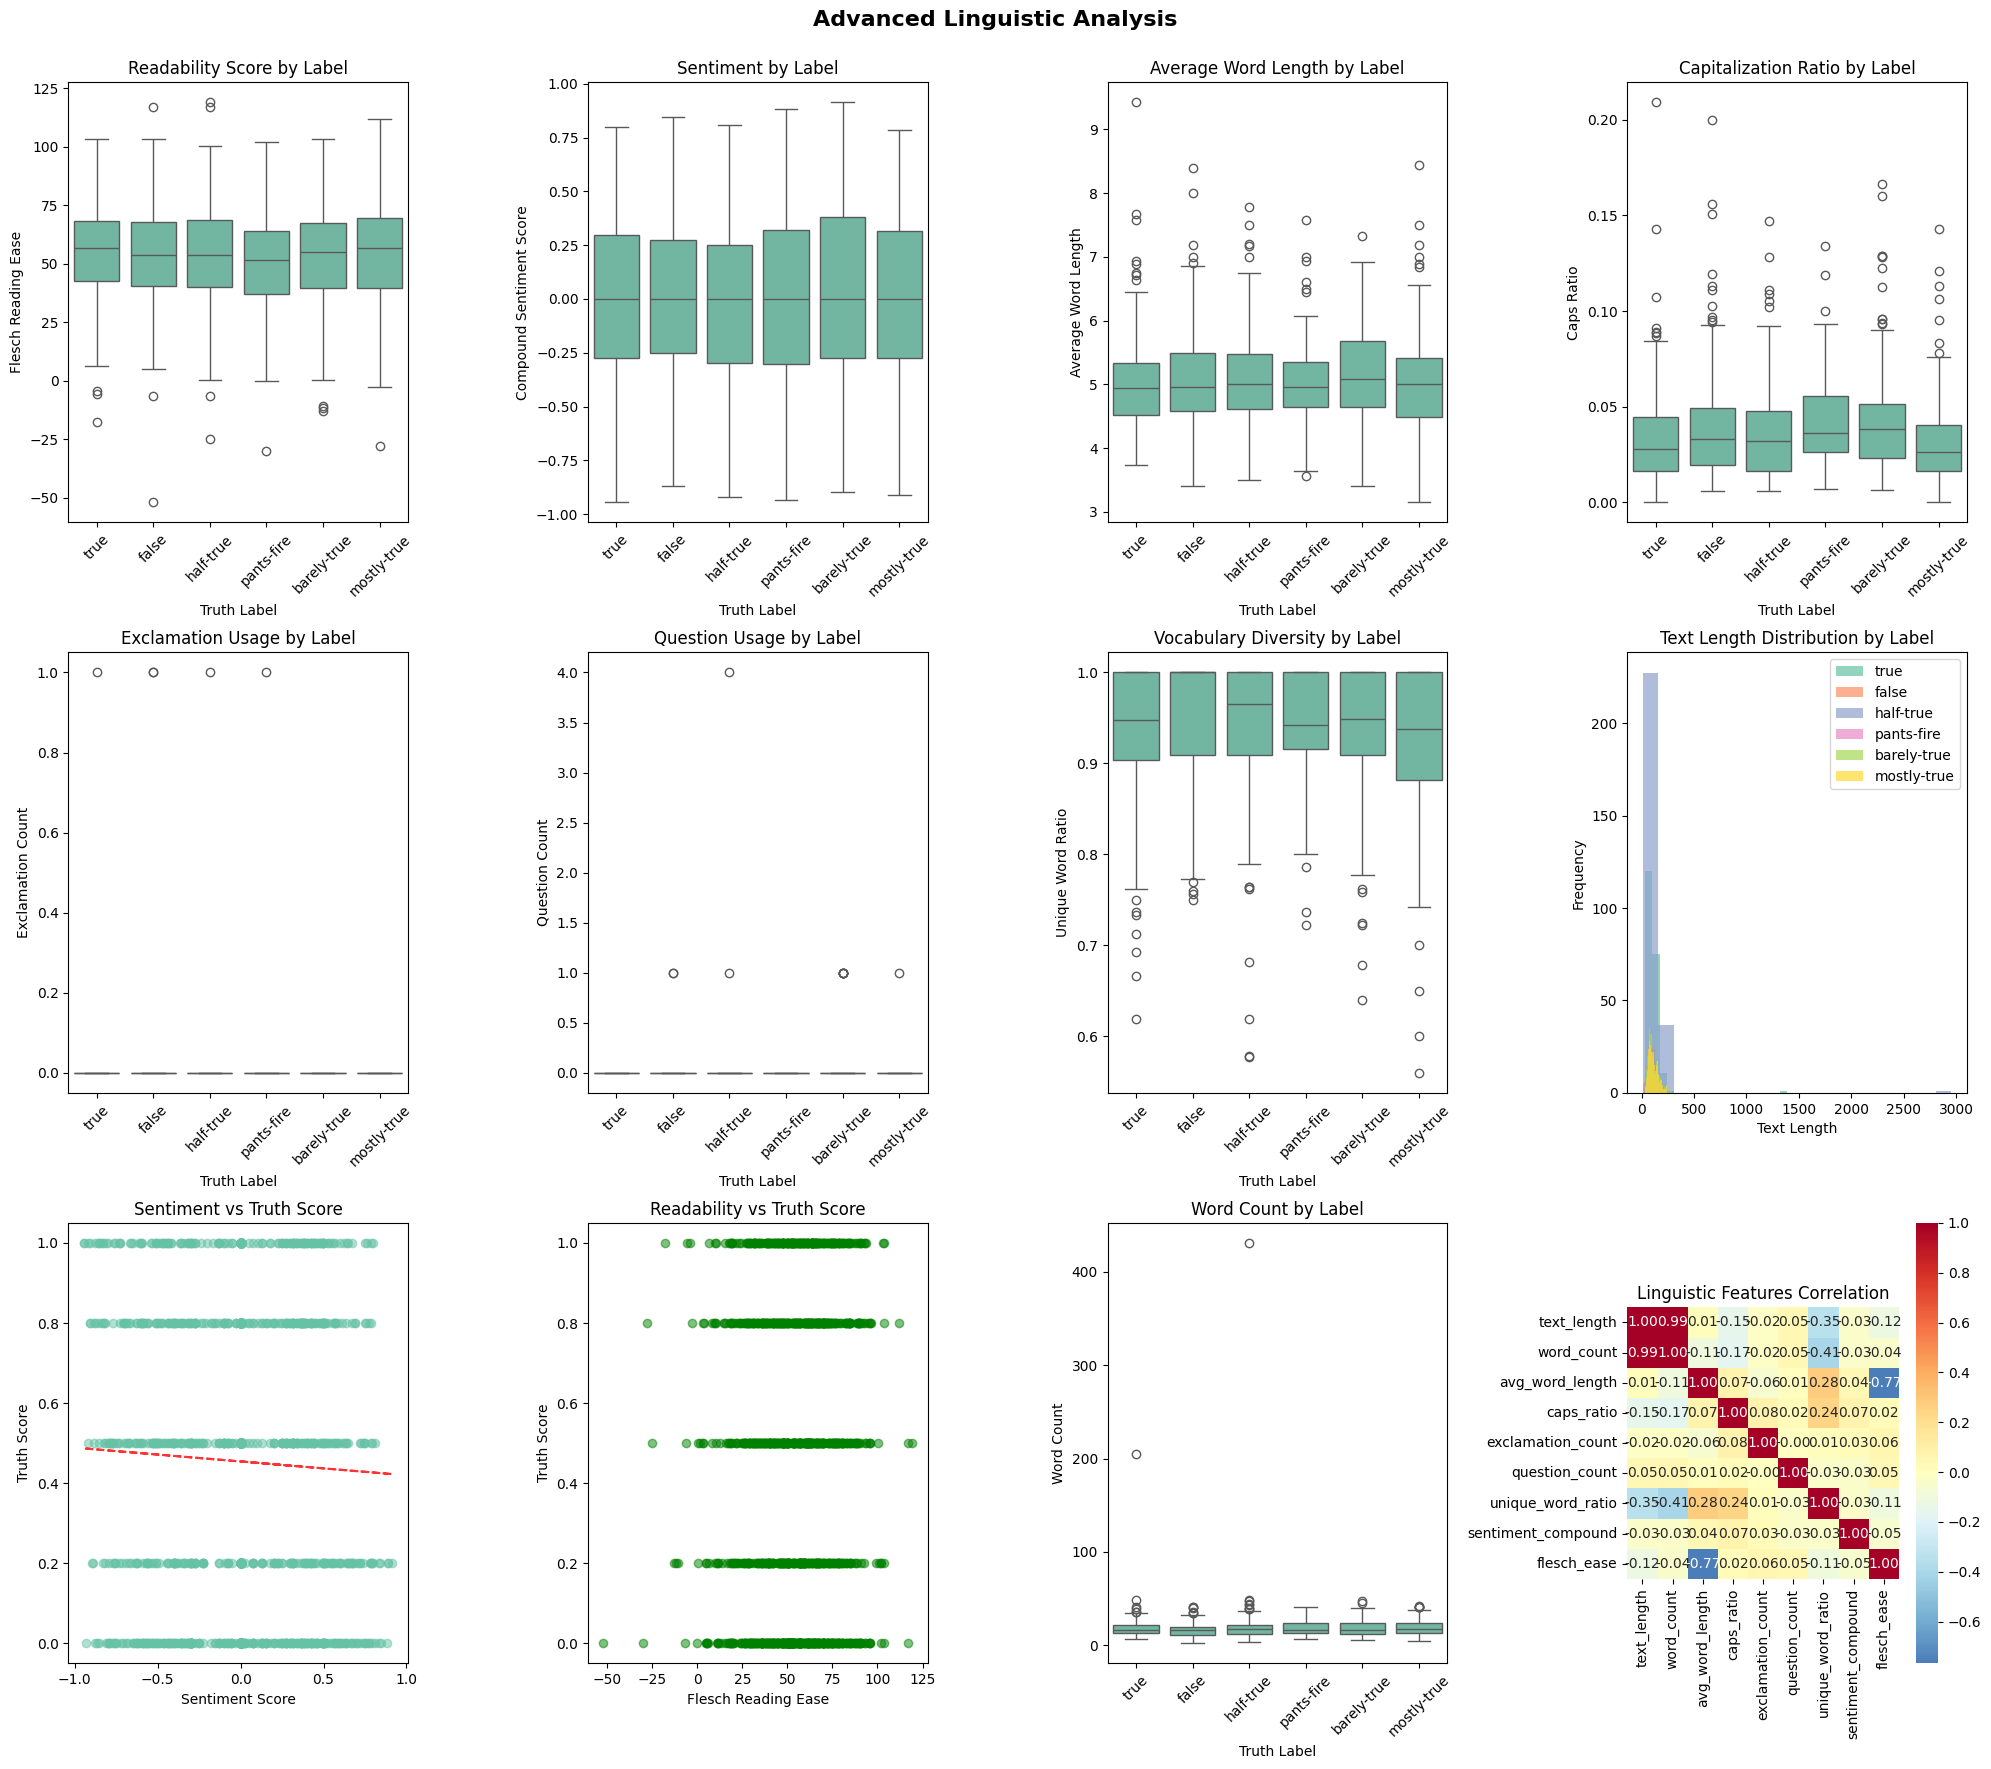

In [9]:
def create_linguistic_visualizations(df):
    """Create comprehensive linguistic analysis visualizations with robust error handling"""
    print("\nCreating linguistic visualizations...")
    
    # Create subplot figure
    fig, axes = plt.subplots(3, 4, figsize=(20, 18))
    fig.suptitle('Advanced Linguistic Analysis', fontsize=16, fontweight='bold')
    
    # 1. Readability by Label
    if 'flesch_ease' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='flesch_ease', ax=axes[0,0])
        axes[0,0].set_title('Readability Score by Label')
        axes[0,0].set_xlabel('Truth Label')
        axes[0,0].set_ylabel('Flesch Reading Ease')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].axis('off')
        print("Skipping Readability plot - required columns missing")
    
    # 2. Sentiment by Label
    if 'sentiment_compound' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='sentiment_compound', ax=axes[0,1])
        axes[0,1].set_title('Sentiment by Label')
        axes[0,1].set_xlabel('Truth Label')
        axes[0,1].set_ylabel('Compound Sentiment Score')
        axes[0,1].tick_params(axis='x', rotation=45)
    else:
        axes[0,1].axis('off')
        print("Skipping Sentiment plot - required columns missing")
    
    # 3. Average Word Length
    if 'avg_word_length' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='avg_word_length', ax=axes[0,2])
        axes[0,2].set_title('Average Word Length by Label')
        axes[0,2].set_xlabel('Truth Label')
        axes[0,2].set_ylabel('Average Word Length')
        axes[0,2].tick_params(axis='x', rotation=45)
    else:
        axes[0,2].axis('off')
        print("Skipping Word Length plot - required columns missing")
    
    # 4. Caps Ratio
    if 'caps_ratio' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='caps_ratio', ax=axes[0,3])
        axes[0,3].set_title('Capitalization Ratio by Label')
        axes[0,3].set_xlabel('Truth Label')
        axes[0,3].set_ylabel('Caps Ratio')
        axes[0,3].tick_params(axis='x', rotation=45)
    else:
        axes[0,3].axis('off')
        print("Skipping Caps Ratio plot - required columns missing")
    
    # 5. Exclamation marks
    if 'exclamation_count' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='exclamation_count', ax=axes[1,0])
        axes[1,0].set_title('Exclamation Usage by Label')
        axes[1,0].set_xlabel('Truth Label')
        axes[1,0].set_ylabel('Exclamation Count')
        axes[1,0].tick_params(axis='x', rotation=45)
    else:
        axes[1,0].axis('off')
        print("Skipping Exclamation plot - required columns missing")
    
    # 6. Question marks
    if 'question_count' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='question_count', ax=axes[1,1])
        axes[1,1].set_title('Question Usage by Label')
        axes[1,1].set_xlabel('Truth Label')
        axes[1,1].set_ylabel('Question Count')
        axes[1,1].tick_params(axis='x', rotation=45)
    else:
        axes[1,1].axis('off')
        print("Skipping Question plot - required columns missing")
    
    # 7. Unique word ratio
    if 'unique_word_ratio' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='unique_word_ratio', ax=axes[1,2])
        axes[1,2].set_title('Vocabulary Diversity by Label')
        axes[1,2].set_xlabel('Truth Label')
        axes[1,2].set_ylabel('Unique Word Ratio')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].axis('off')
        print("Skipping Vocabulary Diversity plot - required columns missing")
    
    # 8. Text length distribution
    if 'text_length' in df.columns and 'label' in df.columns:
        for label in df['label'].unique():
            data = df[df['label'] == label]['text_length']
            axes[1,3].hist(data, alpha=0.7, label=label, bins=20)
        axes[1,3].set_title('Text Length Distribution by Label')
        axes[1,3].set_xlabel('Text Length')
        axes[1,3].set_ylabel('Frequency')
        axes[1,3].legend()
    else:
        axes[1,3].axis('off')
        print("Skipping Text Length Distribution plot - required columns missing")
    
    # 9. Sentiment vs Truth correlation
    if 'sentiment_compound' in df.columns and 'label' in df.columns:
        truth_mapping = {'true': 1.0, 'mostly-true': 0.8, 'half-true': 0.5, 
                         'barely-true': 0.2, 'false': 0.0, 'pants-fire': 0.0}
        df['truth_numeric'] = df['label'].map(truth_mapping)
        
        axes[2,0].scatter(df['sentiment_compound'], df['truth_numeric'], alpha=0.5)
        axes[2,0].set_title('Sentiment vs Truth Score')
        axes[2,0].set_xlabel('Sentiment Score')
        axes[2,0].set_ylabel('Truth Score')
        
        # Add trend line
        if df['sentiment_compound'].notna().any():
            z = np.polyfit(df['sentiment_compound'].dropna(), 
                           df['truth_numeric'].dropna(), 1)
            p = np.poly1d(z)
            axes[2,0].plot(df['sentiment_compound'], p(df['sentiment_compound']), 
                           "r--", alpha=0.8)
    else:
        axes[2,0].axis('off')
        print("Skipping Sentiment vs Truth plot - required columns missing")
    
    # 10. Readability vs Truth
    if 'flesch_ease' in df.columns and 'label' in df.columns:
        if 'truth_numeric' not in df.columns:
            truth_mapping = {'true': 1.0, 'mostly-true': 0.8, 'half-true': 0.5, 
                             'barely-true': 0.2, 'false': 0.0, 'pants-fire': 0.0}
            df['truth_numeric'] = df['label'].map(truth_mapping)
            
        axes[2,1].scatter(df['flesch_ease'], df['truth_numeric'], alpha=0.5, color='green')
        axes[2,1].set_title('Readability vs Truth Score')
        axes[2,1].set_xlabel('Flesch Reading Ease')
        axes[2,1].set_ylabel('Truth Score')
    else:
        axes[2,1].axis('off')
        print("Skipping Readability vs Truth plot - required columns missing")
    
    # 11. Word Count Distribution (replaces Credibility Score)
    if 'word_count' in df.columns and 'label' in df.columns:
        sns.boxplot(data=df, x='label', y='word_count', ax=axes[2,2])
        axes[2,2].set_title('Word Count by Label')
        axes[2,2].set_xlabel('Truth Label')
        axes[2,2].set_ylabel('Word Count')
        axes[2,2].tick_params(axis='x', rotation=45)
    else:
        axes[2,2].axis('off')
        print("Skipping Word Count plot - required columns missing")
    
    # 12. Feature correlation heatmap
    linguistic_features = ['text_length', 'word_count', 'avg_word_length', 
                           'caps_ratio', 'exclamation_count', 'question_count',
                           'unique_word_ratio']
    
    if 'sentiment_compound' in df.columns:
        linguistic_features.append('sentiment_compound')
    if 'flesch_ease' in df.columns:
        linguistic_features.append('flesch_ease')
    
    # Only include features that actually exist in the DataFrame
    existing_features = [f for f in linguistic_features if f in df.columns]
    
    if len(existing_features) > 1:  # Need at least 2 features for correlation
        corr_matrix = df[existing_features].corr()
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlBu_r', center=0,
                    square=True, ax=axes[2,3])
        axes[2,3].set_title('Linguistic Features Correlation')
    else:
        axes[2,3].axis('off')
        print("Skipping Correlation Heatmap - not enough features available")
    
    # Save and show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)  # Adjust top margin for suptitle
    
    # Create directory if it doesn't exist
    import os
    os.makedirs('results/plots', exist_ok=True)
    
    plt.savefig('results/plots/day2_linguistic_analysis.png', dpi=300, bbox_inches='tight')
    print("Linguistic analysis saved to 'results/plots/day2_linguistic_analysis.png'")
    plt.show()

# 4. Call the visualization function
# ----------------------------------------------------------------
create_linguistic_visualizations(df)


🔗 COMPREHENSIVE CORRELATION ANALYSIS
✅ Correlation analysis saved to 'results/plots/day2_correlation_analysis.png'


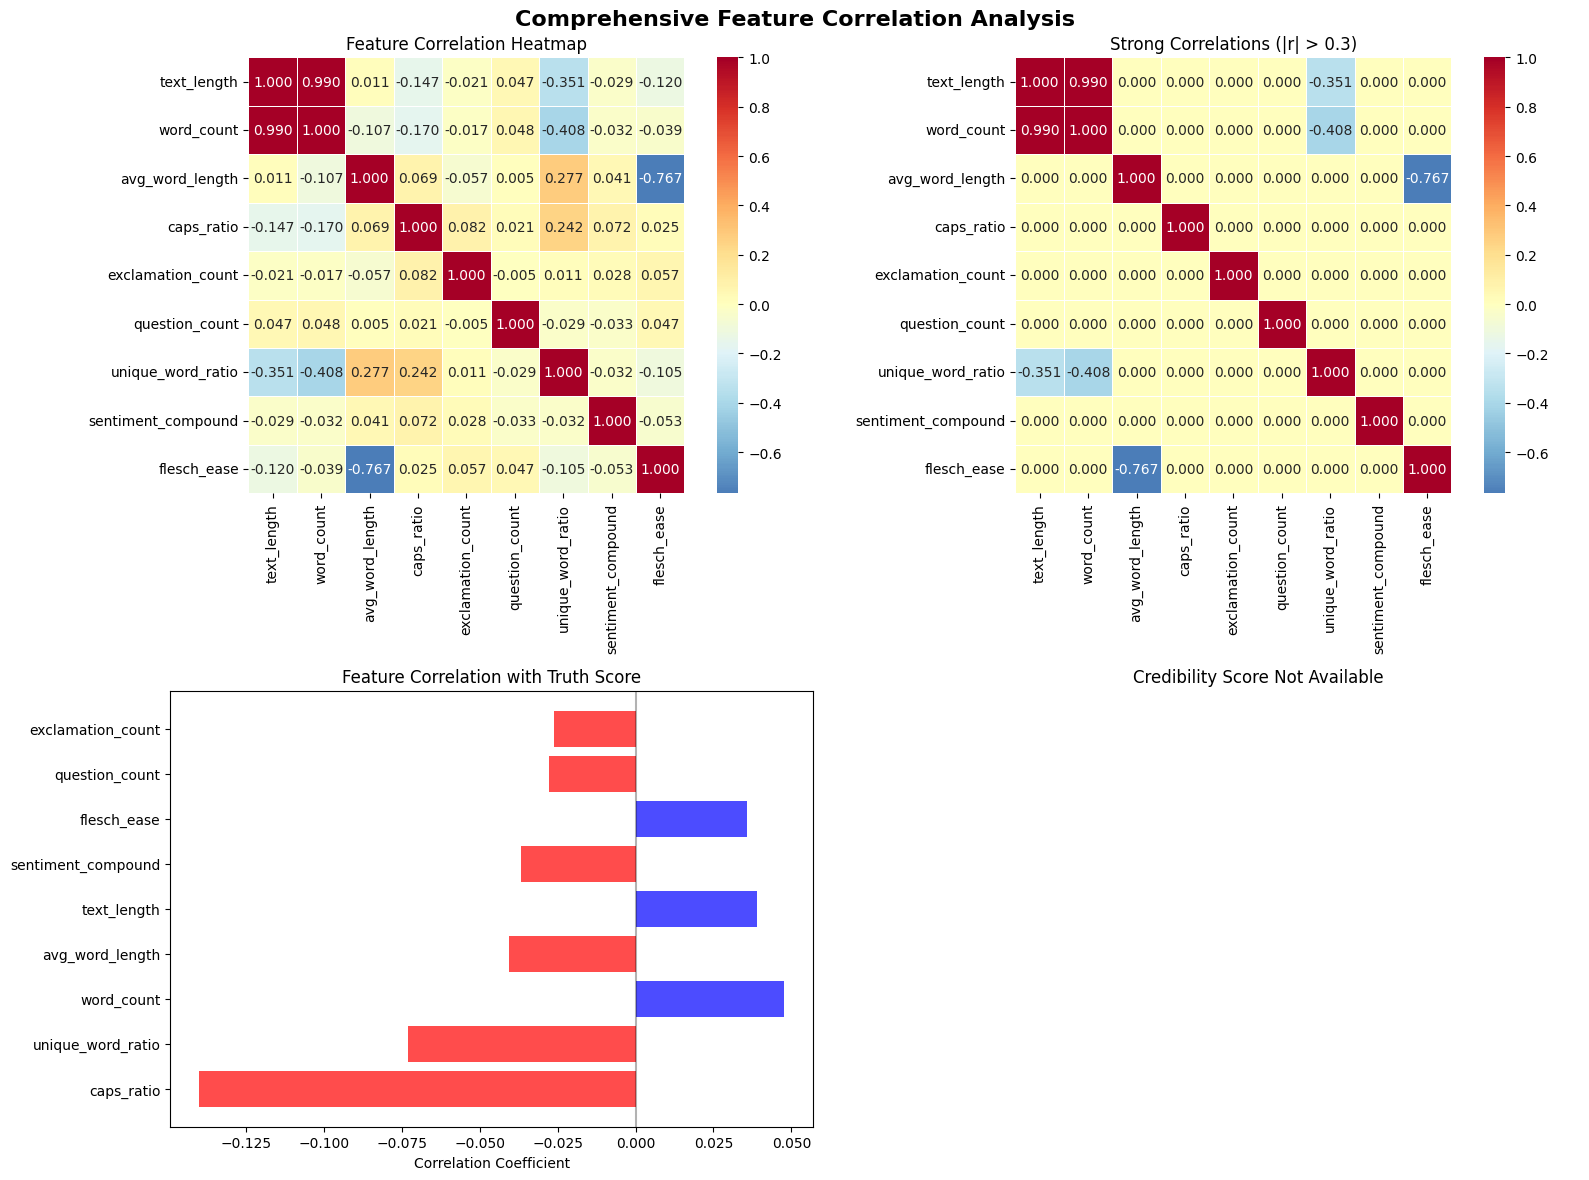


📊 Key Correlation Findings:
Top features correlated with Truth Score:
   caps_ratio: -0.140
   unique_word_ratio: -0.073
   word_count: 0.048
   avg_word_length: -0.041
   text_length: 0.039

⚠️ Credibility Score correlations not available
✅ Morning Session Complete! (10:00 AM)
Next: 11:00 AM - 1:00 PM: Feature correlation analysis and statistical testing


In [12]:
def comprehensive_correlation_analysis(df):
    """Perform comprehensive correlation analysis with robust error handling"""
    print("\n" + "="*50)
    print("🔗 COMPREHENSIVE CORRELATION ANALYSIS")
    print("="*50)
    
    # Base list of features to consider
    potential_features = [
        'text_length', 'word_count', 'avg_word_length', 'caps_ratio',
        'exclamation_count', 'question_count', 'unique_word_ratio',
        'credibility_score', 'total_statements'  # These may or may not exist
    ]
    
    # Add sentiment and readability if available
    if 'sentiment_compound' in df.columns:
        potential_features.append('sentiment_compound')
    if 'flesch_ease' in df.columns:
        potential_features.append('flesch_ease')
    
    # Only include features that actually exist in the DataFrame
    numeric_features = [feat for feat in potential_features if feat in df.columns]
    
    # Check if we have enough features for correlation analysis
    if len(numeric_features) < 2:
        print("⚠️ Not enough numeric features for correlation analysis")
        return None, None, None
    
    # Calculate correlation matrix
    correlation_matrix = df[numeric_features].corr()
    
    # Create comprehensive correlation visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Feature Correlation Analysis', fontsize=16, fontweight='bold')
    
    # 1. Full correlation heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, ax=axes[0,0], fmt='.3f')
    axes[0,0].set_title('Feature Correlation Heatmap')
    
    # 2. Strong correlations only (|r| > 0.3)
    strong_corr = correlation_matrix.copy()
    strong_corr[abs(strong_corr) < 0.3] = 0
    sns.heatmap(strong_corr, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, ax=axes[0,1], fmt='.3f')
    axes[0,1].set_title('Strong Correlations (|r| > 0.3)')
    
    # 3. Correlation with truth score
    if 'truth_numeric' not in df.columns:
        truth_mapping = {'true': 1.0, 'mostly-true': 0.8, 'half-true': 0.5, 
                        'barely-true': 0.2, 'false': 0.0, 'pants-fire': 0.0}
        df['truth_numeric'] = df['label'].map(truth_mapping)
    
    truth_correlations = df[numeric_features + ['truth_numeric']].corr()['truth_numeric'].drop('truth_numeric')
    truth_correlations = truth_correlations.sort_values(key=abs, ascending=False)
    
    colors = ['red' if x < 0 else 'blue' for x in truth_correlations.values]
    axes[1,0].barh(range(len(truth_correlations)), truth_correlations.values, color=colors, alpha=0.7)
    axes[1,0].set_yticks(range(len(truth_correlations)))
    axes[1,0].set_yticklabels(truth_correlations.index, fontsize=10)
    axes[1,0].set_title('Feature Correlation with Truth Score')
    axes[1,0].set_xlabel('Correlation Coefficient')
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # 4. Credibility score correlations (if available)
    if 'credibility_score' in df.columns:
        cred_correlations = df[numeric_features + ['credibility_score']].corr()['credibility_score'].drop('credibility_score')
        cred_correlations = cred_correlations.sort_values(key=abs, ascending=False)
        
        colors = ['red' if x < 0 else 'green' for x in cred_correlations.values]
        axes[1,1].barh(range(len(cred_correlations)), cred_correlations.values, color=colors, alpha=0.7)
        axes[1,1].set_yticks(range(len(cred_correlations)))
        axes[1,1].set_yticklabels(cred_correlations.index, fontsize=10)
        axes[1,1].set_title('Feature Correlation with Credibility Score')
        axes[1,1].set_xlabel('Correlation Coefficient')
        axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    else:
        axes[1,1].axis('off')
        axes[1,1].set_title('Credibility Score Not Available')
        cred_correlations = None
    
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    import os
    os.makedirs('results/plots', exist_ok=True)
    
    plt.savefig('results/plots/day2_correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Correlation analysis saved to 'results/plots/day2_correlation_analysis.png'")
    plt.show()
    
    # Print key findings
    print("\n📊 Key Correlation Findings:")
    print("Top features correlated with Truth Score:")
    for feature, corr in truth_correlations.head(5).items():
        print(f"   {feature}: {corr:.3f}")
    
    if cred_correlations is not None:
        print("\nTop features correlated with Credibility Score:")
        for feature, corr in cred_correlations.head(5).items():
            print(f"   {feature}: {corr:.3f}")
    else:
        print("\n⚠️ Credibility Score correlations not available")
    
    return correlation_matrix, truth_correlations, cred_correlations

# Perform correlation analysis
corr_matrix, truth_corrs, cred_corrs = comprehensive_correlation_analysis(df)

print("✅ Morning Session Complete! (10:00 AM)")
print("Next: 11:00 AM - 1:00 PM: Feature correlation analysis and statistical testing")